# GAN Generate Images


We will generate images from Fashion MNIST dataset

In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# Hyper-parameters
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 200
batch_size = 100
sample_dir = 'samples'

# Create a directory if not exists
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

# Image processing
# transform = transforms.Compose([
#                 transforms.ToTensor(),
#                 transforms.Normalize(mean=(0.5, 0.5, 0.5),   # 3 for RGB channels
#                                      std=(0.5, 0.5, 0.5))])
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5],   # 1 for greyscale channels
                                     std=[0.5])])

In [ ]:
# MNIST dataset
mnist = torchvision.datasets.MNIST(root='../../data/', train=True, transform=transform, download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True)

# Discriminator
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

# Generator 
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../../data/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/MNIST/raw



In [ ]:
# Device setting
D = D.to(device)
G = G.to(device)

# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

In [ ]:
# Start training
total_step = len(data_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)
        
        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels == 1
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        # Compute loss with fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        
        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, real_labels)
        
        # Backprop and optimize
        reset_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
    
    # Save real images
    if (epoch+1) == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))
    
    # Save sampled images
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))

# Save the model checkpoints 
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

Epoch [0/200], Step [200/600], d_loss: 0.0452, g_loss: 4.1022, D(x): 0.99, D(G(z)): 0.04
Epoch [0/200], Step [400/600], d_loss: 0.1533, g_loss: 5.2106, D(x): 0.93, D(G(z)): 0.05
Epoch [0/200], Step [600/600], d_loss: 0.0406, g_loss: 5.1165, D(x): 0.98, D(G(z)): 0.01
Epoch [1/200], Step [200/600], d_loss: 0.2336, g_loss: 4.1145, D(x): 0.92, D(G(z)): 0.07
Epoch [1/200], Step [400/600], d_loss: 0.0640, g_loss: 7.2835, D(x): 0.97, D(G(z)): 0.02
Epoch [1/200], Step [600/600], d_loss: 0.1604, g_loss: 4.5873, D(x): 0.97, D(G(z)): 0.11
Epoch [2/200], Step [200/600], d_loss: 0.5599, g_loss: 3.2239, D(x): 0.81, D(G(z)): 0.14
Epoch [2/200], Step [400/600], d_loss: 0.2412, g_loss: 3.5366, D(x): 0.93, D(G(z)): 0.07
Epoch [2/200], Step [600/600], d_loss: 0.5510, g_loss: 3.7298, D(x): 0.84, D(G(z)): 0.24
Epoch [3/200], Step [200/600], d_loss: 1.1650, g_loss: 1.6444, D(x): 0.66, D(G(z)): 0.29
Epoch [3/200], Step [400/600], d_loss: 1.8809, g_loss: 1.6471, D(x): 0.67, D(G(z)): 0.60
Epoch [3/200], Step [

TypeError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Reference Taken from Video tutorial - GAN using DNN on MNIST Dataset

In [ ]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from tensorflow.keras import layers

import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image

In [ ]:
(train_images, _), (_,_) = tf.keras.datasets.fashion_mnist.load_data()
train_images.shape # there are 60000 images of dimension 28x28 consisting of grayscale image(1 channel)

4422102/4422102 [==============================] - 0s 0us/step


(60000, 28, 28)

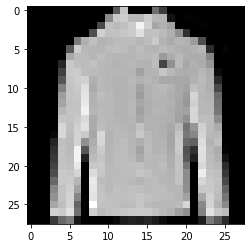

In [ ]:
plt.imshow(train_images[56782,:,:] ,cmap='gray')

In [ ]:
train_images.shape[0]

60000

In [ ]:
train_images = train_images.reshape(train_images.shape[0],28,28,1).astype('float32')
train_images.shape # batch_size, height, width and no. of channels=1

(60000, 28, 28, 1)

In [ ]:
# Lets have a look at a sample of an image
train_images[56782,:10,:10]

array([[[  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  1.],
        [  1.],
        [  0.],
        [  0.],
        [  0.]],

       [[  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  1.],
        [  0.],
        [  0.]],

       [[  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  1.],
        [  0.],
        [  0.],
        [  0.],
        [ 74.]],

       [[  0.],
        [  0.],
        [  0.],
        [  0.],
        [  1.],
        [  0.],
        [  0.],
        [  0.],
        [ 77.],
        [207.]],

       [[  0.],
        [  0.],
        [  0.],
        [  1.],
        [  0.],
        [  0.],
        [124.],
        [176.],
        [192.],
        [180.]],

       [[  0.],
        [  0.],
        [  0.],
        [  1.],
        [  0.],
        [ 88.],
        [207.],
        [184.],
        [183.],
        [182.]],

       [[  0.],
        [  0

In [ ]:
# Re-center OR Normalize OR Re-scaling Operation
train_images = (train_images-127.5)/127.5
# The image pixel values will be ranging between -1 to 1
# Another reason behind this re-scaling is that the fake images generated by the Generator model of GAN will also have the pixel value in this range

In [ ]:
train_images[56782,:10,:10]

array([[[-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-0.99215686],
        [-0.99215686],
        [-1.        ],
        [-1.        ],
        [-1.        ]],

       [[-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-0.99215686],
        [-1.        ],
        [-1.        ]],

       [[-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-0.99215686],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-0.41960785]],

       [[-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-0.99215686],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-0.39607844],
        [ 0.62352943]],

       [[-1.        ],
        [-1.        ],
        [-1.        ],
   

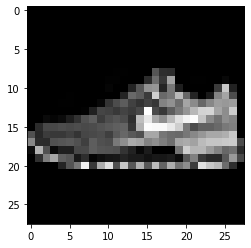

In [ ]:
# Lets have a look at a single image using matplotlib
plt.imshow(train_images[2567].squeeze(), cmap='gray') 
# squeezed [ndarray] The input array, but with all or a subset of the dimensions of length 1 removed. This is always a itself or a view into arr.

In [ ]:
# before feeding this images into GAN, we are going to shuffle these images and then set a batch_size for training
buffer_size = 60000
batch_size = 128

In [ ]:
# we will now be representing this images into a tensorflow dataset (very useful for building the Machine Learning pipelines)
# Setting up the training dataset from tensor slices, so that we can load data in batches
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)

### 1st Step - Generator Model

In [ ]:

# Generator Model is the counter Feature in this operation. The responsibility of the generator model is to take in latent noise variables and generate fake images that 
# look like the real images
# Initially the fake images are worst identified but as the training progresses, the generator will get better.

# GENERATOR MODEL - Its a simple sequential model, meaning, the connections between layers one after the other in a sequence. 

def generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(64, input_dim=100)) # The input dimsion = 100 which is the latent noise variable which we feed into the generator in order for it to 
                                             # generate images starting from noise.
  model.add(layers.ReLU())

  model.add(layers.Dense(128))
  model.add(layers.ReLU())

  model.add(layers.Dense(256))
  model.add(layers.ReLU())
  
  model.add(layers.Dense(784, activation='tanh')) # 28x28=784 and tanh gives an output in range -1 to 1. 
                                                  # The size of this o/p layer corresponds to the image generate by our generator network
  model.add(layers.Reshape((28,28,1))) # The fake images generated will be of the same size as the real image in our dataset.

  return model
  

In [ ]:
generator = generator_model()
generator.summary() # high level summary of our generator network architecture

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                6464      
                                                                 
 re_lu (ReLU)                (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 re_lu_1 (ReLU)              (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 re_lu_2 (ReLU)              (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 784)               2

In [ ]:
# Example how we would generate a latent noise variable vector in order to feed into the generator model
# We have used the tf.random.normal() function to generate Gaussian Noise and our vector size is 100 i.e. equal to the input dimension of our generator model
noise = tf.random.normal([1,100])
# We pass onto the latent noise vector to our genertor model. So, set training to false to see what the generated image looks like
generated_image = generator(noise, training=False)

generated_image.shape

# Generator Model takes noise as an input and then produces fake image

TensorShape([1, 28, 28, 1])

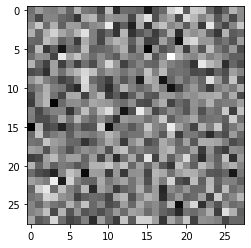

In [ ]:
# our generator has not been trained yet, so it looks like this.
plt.imshow(generated_image[0,:,:,0], cmap='gray')

2nd Step - Discriminator Model

In [ ]:
# Discriminator is just a simple classification model which is suppose to determine whether the input which has been fed into it is real or fake.
# Discriminator Model is also a sequential keras model

# DISCRIMINATOR MODEL

def discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Input(shape = (28, 28, 1))) # The input to the discriminator model is an image with shape 28x28 pixels and single channel gray scaled images.
  model.add(layers.Flatten()) # Because we are building our GAN using Dense Neural Network, we need to flatten this input image. So the image is represented as 
                              # a single dimensional vector that is then passed into the dense layers of the discriminator.

  model.add(layers.Dense(256))
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Dropout(0.5))

  model.add(layers.Dense(128))
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Dropout(0.3))

  model.add(layers.Dense(64))
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Dropout(0.2))

  model.add(layers.Dense(1, activation='sigmoid')) 
  
  return model

In [ ]:
discriminator = discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               200960    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128)               0         
                                                                 
 dropout_1 (Dropout)         (None, 128)              

In [ ]:
# Now we have the generated image that we got from our untrained generator model and pass it through this discriminator. Our generated image was pure noise.
# Now lets see what our discriminator considers it to be fake or real.
discriminator = discriminator_model()
output = discriminator(generated_image)
print(output) # The output comes out to be a probability close to 0.5, i.e. its fake image

tf.Tensor([[0.4469082]], shape=(1, 1), dtype=float32)


#### Now that we have the Neural networks which make the adversaries, the generator and the discriminator, the next step here is to define the loss function

In [ ]:
# loss used for classification models - two categories for real and fake image. The same loss will be used for trainng purpose of discriminator as well as the generator.
bce = tf.keras.losses.BinaryCrossentropy() # BinaryCrossentropy heaviliy penalizes the misclassification by the discriminator

In [ ]:
# Objective of the discriminator_loss is to classify the images from the real dataset
# are real and the images generated by the generator are fake classified
# Real Images are classified using category one
# Fake Images are classified using category zero
# Real_output = output of the discriminator for real images
# Fake_output = output of the discriminator for fake images fed into the discriminator
# We'll use these to computer the loss
def discriminator_loss(real_output, fake_output):
  # So, whats the loss of the discriminator on the real data?
  # We want the real data to be classified as ones or real. So the output of the
  # discriminator we compare to a tensor of ones and this real loss of the discriminator
  real_loss = bce(tf.ones_like(real_output), real_output) 
  # We want the discriminator to classifiy fake images as zeros.
  # So we take the o/p of the discriminator on fake images, i.e., fake_output and compare
  # that o/p to a tensor of all zeros.
  # And we use that to compute the fake binary cross entropy loss
  fake_loss = bce(tf.zeros_like(fake_output), fake_output) 
  # The total sum of the loss is the sum of these two losses -> (real_loss + fake_loss) 
  # when we train this model, we try to minimize this loss of discriminator
  # Minimizing this loss is equivalent to the maximizing the probability that real images
  # are classified as real and generated images are classified as fake.
  total_loss = real_loss + fake_loss 
  return total_loss


##### Training means the training of two Neural N/w - The generator & the discriminator.
This means that we have to defin the loss of the generator loss as well.

In [ ]:
# Here fake_output is the o/p of the discriminator for the fake data generator by the generator.
# The objective of the generator is to fool the discriminator - means the generator wants the 
# discriminator to classify its fake data as real.
# So inorder to compute the generator loss we take the o/p of the discriminator for fake data and 
# compare that p/p to a tensor of all once.
# When this loss is minimized, means the discriminator is classifying more and more of the fake data
# as real
def generator_loss(fake_output):
  gen_loss = bce(tf.ones_like(fake_output), fake_output)
  return gen_loss

In [ ]:
# Using the Adam Optimizers - which uses Gradient Descent using an exponentially weighted average of gradients
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
# Checkpoint is the training Process at regular intervals.
# So if the training is interupted for any reason, it can be picked up
# from the last check point
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
# tf.train.Checkpoint takes in as an i/p the optimizers for the two Neural N/w (generator and the discriminator)
# as well as the neural network themselves.
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer, 
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

### Having setup our Neural N/W and the loss functions, we are ready to traing process.

In [ ]:
epochs = 50
noise_dim = 100 # The vector that represents the noise i/p to out generator will have a dimensionality of 100
num_examples_to_generate = 16 # After every epoch of training, we'll generate 16 examples from our GAN to see what 
# the generated images looks like. These 16 images will be generated by 16 different noise vectors ecah of dimensionality 100

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# Next define a python function annotated with @tf.function that defines a single trainng step for my GAN
# A tf.function is a python annotation that serves as a trasformation tool and
# creates python-independent data flow graphs out of your python code.
# At tf.function applied to our train step, we'll generate our neural network graph.
# We take in the images as an input argument.

@tf.function
def train_step(images):
  # At every step we will generate a batch of noise. This will be the i/p to our generator model
  # in order to generate images
  noise = tf.random.normal([batch_size, noise_dim])

  # GradientTape() is tensorflow library to perform the gradient descent in order to train Neural N/w
  # We are training two different Neural N/w for every pass through every batch of our data.
  # The two NNs are - the generator & the discriminator
  # That's why we instantiate two gradient tapes - gen_tape and disc_tape
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

    # We will be training the generator and the discriminator alternately.
    # 1st we'll generate the fake images from the generator.
    # we'll pass in our batch of noise to the generator and get generated images
    # Since it's a traing phase, we'll set training = True
    generated_images = generator(noise, training = True)

    # Once we gave the fake data o/p from the generator, we now use this to train the discriminator
    # Now we'll train the discriminator on the real images as well as the fake images

    # we will pass the images from our training data in line [30]. This will give us the o/p of the discriminator 
    # from images in the real dataset
    real_output = discriminator(images, training=True)
    # we now pass the generated images through the discriminator as well in line [34]
    # This will give us the o/p of the discriminator for the fake image
    fake_output = discriminator(generated_images, training=True)

    # Next we compute the discriminator loss by invoking the discriminator loss function
    disc_loss = discriminator_loss(real_output, fake_output)
    # We also compute the generator_loss which takes the o/p generated by the discriminator as i/p
    gen_loss = generator_loss(fake_output)

  # Once we have the loss for both the adversary n/w, we can use the GradientTape() to computer the gradients for
  # the generator as well as the discriminator.
  # Note that we use the generator laws to computer the gradients the generator & the discriminator laws for gradients of discriminator
  # These are two seperate NNs after all.
  gradient_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradient_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  # we then apply the optimizers to update the model parameters for both the the generator & the discriminator
  # For every bach of training we return a bunch of information - the generator loss, the discriminator loss, 
  # the accuracy of the discriminator on a real data, the accuracy of the discriminator on a fake data
  generator_optimizer.apply_gradients(zip(gradient_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradient_of_discriminator, discriminator.trainable_variables))

  return (gen_loss, disc_loss, tf.reduce_mean(real_output), tf.reduce_mean(fake_output))


In [ ]:
# During the training process we use this helper function to generate and plot images 
# to get the generator to generate the images from the test input that we have specified.

def generate_and_plot_images(model, epoch , test_input):

  # The model here is the generator. We'll get the o/p of the generator, for the test noise 
  # input that we had set up earlier.
  predictions = model(test_input, training = False)

  fig = plt.figure(figsize=(8,4))
  for i in range(predictions.shape[0]):
    plt.subplot(4,4, i+1)
    pred = (predictions[i, :, :, 0] + 1) * 127.5
    pred = np.array(pred)
    plt.imshow(pred.astype(np.uint8), cmap = 'gray')
    plt.axis('off')

  plt.savefig('image_at_epch_{:04d}.png'.format(epoch))
  plt.show()

# This will allow us to see how the generator improves over time.

Training of the GAN model

In [ ]:
def train(dataset, epochs):
  
  # list used for plotting
  gen_loss_list = [] 
  disc_loss_list = []

  # list used for accuracies score for the discriminator on real and fake data
  real_score_list = []
  fake_score_list = []

  # run for no. of epochs
  # for every epoch we'll split our real training dataset into batches and feed
  # in this data one batch at a time
  for epoch in tqdm(range(epochs)):
    start = time.time()
    num_batches = len(dataset)

    print(f'Training started with epoch {epoch + 1} with {num_batches} batches...')

    # Variables for total generator loss and the total discriminator loss
    total_gen_loss = 0
    total_disc_loss = 0

    # for every batch of the i/p data, the train_step will train the generator and the discriminator
    # on this batch of data.
    # The train_step function - generates fake images, feeds real as well as fake images to the 
    # discriminator, computes loss, computes gradients for both of our adversary N/W, and updates
    # both the model parameters
    for batch in dataset:
      generator_loss, discriminator_loss, real_score, fake_score = train_step(batch)
      total_gen_loss += generator_loss
      total_disc_loss += discriminator_loss

    # Computer the average loss of the epoch, this mean values will be print out on screen
    mean_gen_loss = total_gen_loss / num_batches
    mean_disc_loss = total_disc_loss / num_batches

    print('Losses after epoch %5d: generator %.3f, discriminator %.3f, real_score %.2f%%, fake_score %.2f%%' %
          (epoch + 1, generator_loss, discriminator_loss, real_score * 100, fake_score * 100))
    
    # generate_and_plot_images function is invokes to feed in our test noise sample, i.e. seed
    # That is our seed and see what is the o/p looks like after the current epoch of training
    generate_and_plot_images(generator, epoch + 1, seed)

    gen_loss_list.append(mean_gen_loss)
    disc_loss_list.append(mean_disc_loss)
    real_score_list.append(real_score)
    fake_score_list.append(fake_score)

    if (epoch + 1) % 10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  return gen_loss_list, disc_loss_list, real_score_list, fake_score_list

  0%|          | 0/50 [00:00<?, ?it/s]

Training started with epoch 1 with 469 batches...
Losses after epoch     1: generator 3.036, discriminator 0.252, real_score 91.49%, fake_score 8.01%


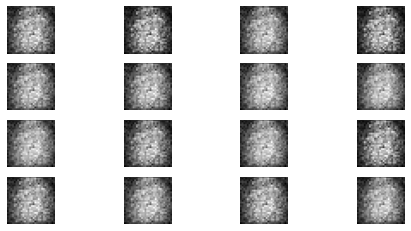

  2%|▏         | 1/50 [00:08<07:07,  8.73s/it]

Time for epoch 1 is 8.733543634414673 sec
Training started with epoch 2 with 469 batches...
Losses after epoch     2: generator 6.444, discriminator 0.701, real_score 83.78%, fake_score 26.64%


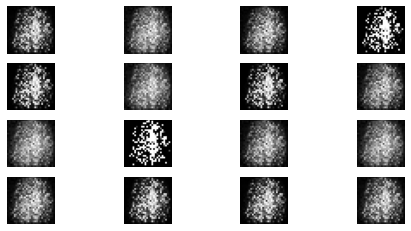

  4%|▍         | 2/50 [00:11<04:07,  5.15s/it]

Time for epoch 2 is 2.623528003692627 sec
Training started with epoch 3 with 469 batches...
Losses after epoch     3: generator 2.480, discriminator 0.570, real_score 85.32%, fake_score 16.72%


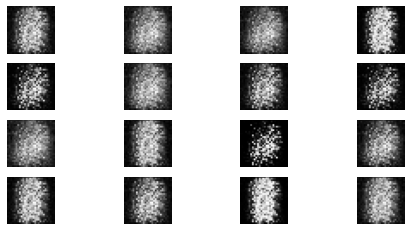

  6%|▌         | 3/50 [00:13<02:58,  3.80s/it]

Time for epoch 3 is 2.1903069019317627 sec
Training started with epoch 4 with 469 batches...
Losses after epoch     4: generator 2.384, discriminator 0.816, real_score 77.87%, fake_score 19.52%


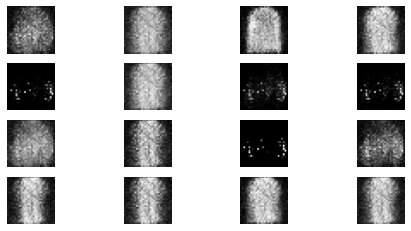

  8%|▊         | 4/50 [00:15<02:28,  3.23s/it]

Time for epoch 4 is 2.359961748123169 sec
Training started with epoch 5 with 469 batches...
Losses after epoch     5: generator 3.299, discriminator 0.230, real_score 94.67%, fake_score 10.04%


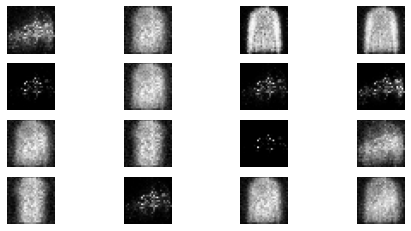

 10%|█         | 5/50 [00:17<02:06,  2.80s/it]

Time for epoch 5 is 2.0270802974700928 sec
Training started with epoch 6 with 469 batches...
Losses after epoch     6: generator 2.585, discriminator 0.448, real_score 85.35%, fake_score 13.61%


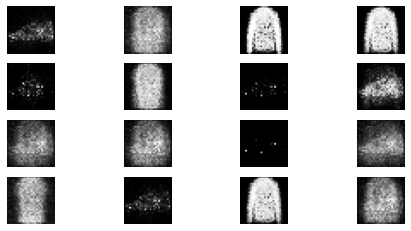

 12%|█▏        | 6/50 [00:20<01:52,  2.56s/it]

Time for epoch 6 is 2.0958385467529297 sec
Training started with epoch 7 with 469 batches...
Losses after epoch     7: generator 1.757, discriminator 0.704, real_score 77.02%, fake_score 23.20%


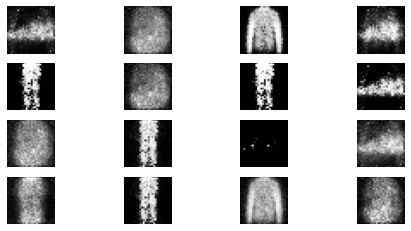

 14%|█▍        | 7/50 [00:22<01:43,  2.40s/it]

Time for epoch 7 is 2.0585994720458984 sec
Training started with epoch 8 with 469 batches...
Losses after epoch     8: generator 3.197, discriminator 0.540, real_score 86.97%, fake_score 14.23%


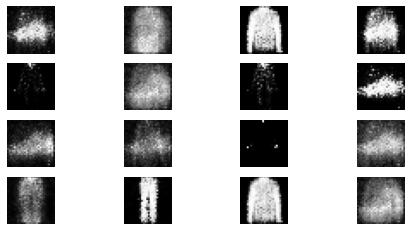

 16%|█▌        | 8/50 [00:24<01:37,  2.32s/it]

Time for epoch 8 is 2.1455020904541016 sec
Training started with epoch 9 with 469 batches...
Losses after epoch     9: generator 2.368, discriminator 0.405, real_score 88.90%, fake_score 16.40%


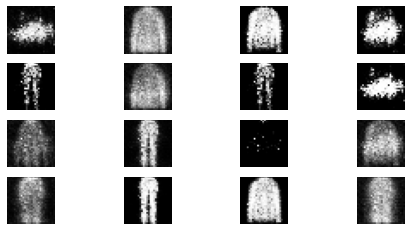

 18%|█▊        | 9/50 [00:26<01:36,  2.35s/it]

Time for epoch 9 is 2.4125924110412598 sec
Training started with epoch 10 with 469 batches...
Losses after epoch    10: generator 2.355, discriminator 0.490, real_score 87.00%, fake_score 18.24%


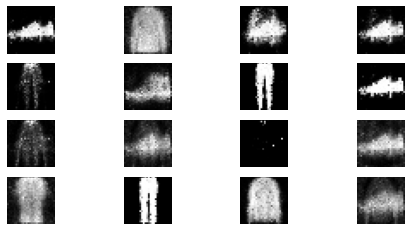

 20%|██        | 10/50 [00:28<01:31,  2.29s/it]

Time for epoch 10 is 2.1384401321411133 sec
Training started with epoch 11 with 469 batches...
Losses after epoch    11: generator 2.837, discriminator 0.252, real_score 94.81%, fake_score 12.16%


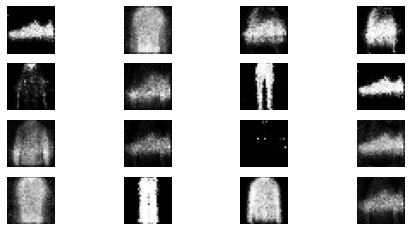

 22%|██▏       | 11/50 [00:30<01:26,  2.23s/it]

Time for epoch 11 is 2.082186698913574 sec
Training started with epoch 12 with 469 batches...
Losses after epoch    12: generator 2.579, discriminator 0.662, real_score 78.52%, fake_score 16.51%


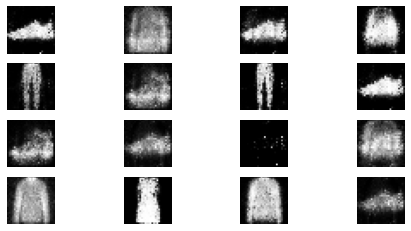

 24%|██▍       | 12/50 [00:33<01:23,  2.19s/it]

Time for epoch 12 is 2.113093614578247 sec
Training started with epoch 13 with 469 batches...
Losses after epoch    13: generator 3.126, discriminator 0.587, real_score 82.08%, fake_score 13.68%


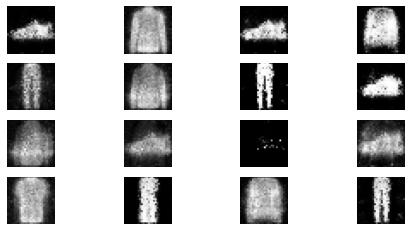

 26%|██▌       | 13/50 [00:35<01:23,  2.27s/it]

Time for epoch 13 is 2.4282591342926025 sec
Training started with epoch 14 with 469 batches...
Losses after epoch    14: generator 1.916, discriminator 0.568, real_score 78.66%, fake_score 18.27%


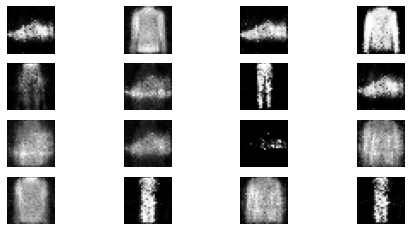

 28%|██▊       | 14/50 [00:37<01:20,  2.24s/it]

Time for epoch 14 is 2.177962303161621 sec
Training started with epoch 15 with 469 batches...
Losses after epoch    15: generator 2.463, discriminator 0.620, real_score 76.85%, fake_score 16.07%


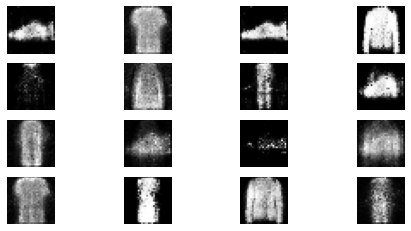

 30%|███       | 15/50 [00:39<01:17,  2.22s/it]

Time for epoch 15 is 2.1658105850219727 sec
Training started with epoch 16 with 469 batches...
Losses after epoch    16: generator 3.012, discriminator 0.599, real_score 81.34%, fake_score 13.98%


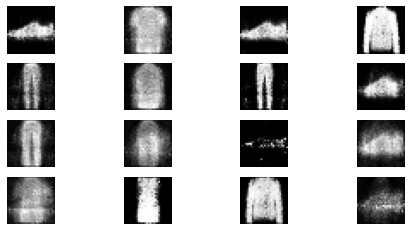

 32%|███▏      | 16/50 [00:41<01:14,  2.18s/it]

Time for epoch 16 is 2.081472396850586 sec
Training started with epoch 17 with 469 batches...
Losses after epoch    17: generator 1.946, discriminator 0.756, real_score 83.89%, fake_score 27.34%


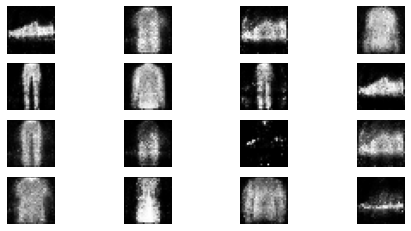

 34%|███▍      | 17/50 [00:44<01:13,  2.23s/it]

Time for epoch 17 is 2.3587334156036377 sec
Training started with epoch 18 with 469 batches...
Losses after epoch    18: generator 2.039, discriminator 0.635, real_score 77.38%, fake_score 21.05%


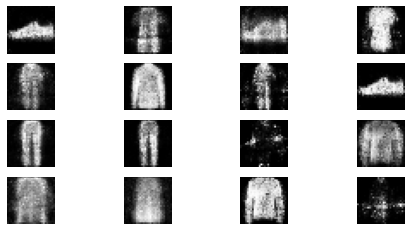

 36%|███▌      | 18/50 [00:46<01:09,  2.19s/it]

Time for epoch 18 is 2.0715997219085693 sec
Training started with epoch 19 with 469 batches...
Losses after epoch    19: generator 1.801, discriminator 0.793, real_score 74.43%, fake_score 24.30%


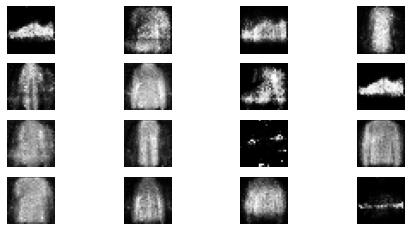

 38%|███▊      | 19/50 [00:48<01:07,  2.17s/it]

Time for epoch 19 is 2.118588924407959 sec
Training started with epoch 20 with 469 batches...
Losses after epoch    20: generator 2.029, discriminator 0.714, real_score 75.22%, fake_score 20.21%


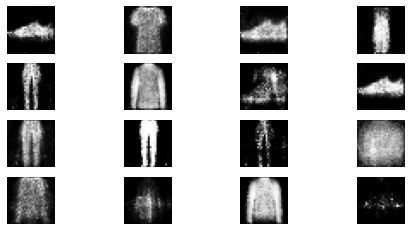

 40%|████      | 20/50 [00:50<01:05,  2.19s/it]

Time for epoch 20 is 2.231332540512085 sec
Training started with epoch 21 with 469 batches...
Losses after epoch    21: generator 1.914, discriminator 0.745, real_score 75.51%, fake_score 22.06%


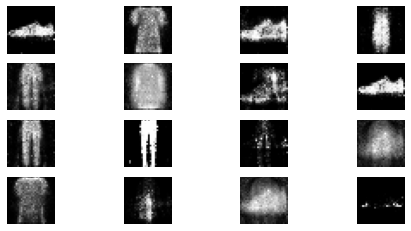

 42%|████▏     | 21/50 [00:52<01:03,  2.18s/it]

Time for epoch 21 is 2.1425087451934814 sec
Training started with epoch 22 with 469 batches...
Losses after epoch    22: generator 3.381, discriminator 0.472, real_score 83.38%, fake_score 9.83%


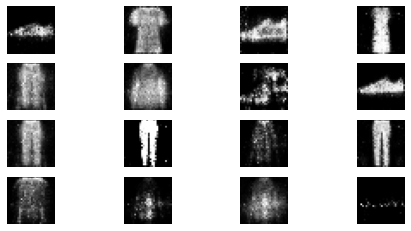

 44%|████▍     | 22/50 [00:55<01:02,  2.23s/it]

Time for epoch 22 is 2.354698896408081 sec
Training started with epoch 23 with 469 batches...
Losses after epoch    23: generator 2.447, discriminator 0.440, real_score 84.28%, fake_score 14.46%


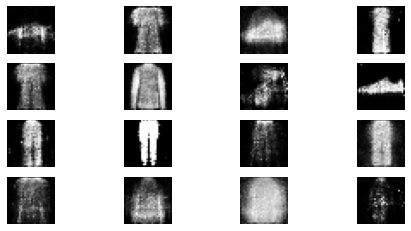

 46%|████▌     | 23/50 [00:57<00:58,  2.17s/it]

Time for epoch 23 is 2.028097629547119 sec
Training started with epoch 24 with 469 batches...
Losses after epoch    24: generator 1.851, discriminator 0.663, real_score 79.79%, fake_score 24.50%


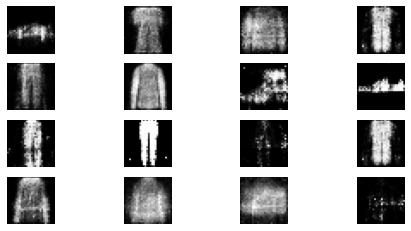

 48%|████▊     | 24/50 [00:59<00:55,  2.13s/it]

Time for epoch 24 is 2.0384457111358643 sec
Training started with epoch 25 with 469 batches...
Losses after epoch    25: generator 1.864, discriminator 0.914, real_score 71.40%, fake_score 26.10%


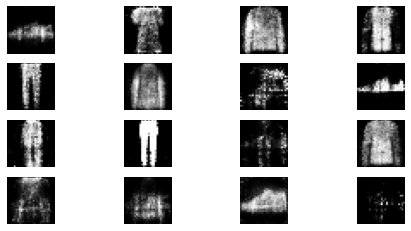

 50%|█████     | 25/50 [01:01<00:52,  2.11s/it]

Time for epoch 25 is 2.046086311340332 sec
Training started with epoch 26 with 469 batches...
Losses after epoch    26: generator 2.495, discriminator 1.141, real_score 70.66%, fake_score 18.14%


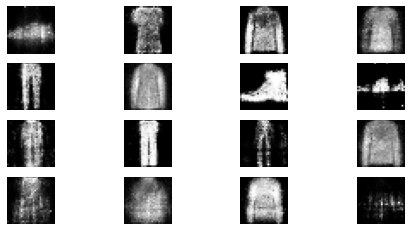

 52%|█████▏    | 26/50 [01:03<00:51,  2.17s/it]

Time for epoch 26 is 2.289527654647827 sec
Training started with epoch 27 with 469 batches...
Losses after epoch    27: generator 1.943, discriminator 0.502, real_score 88.15%, fake_score 22.22%


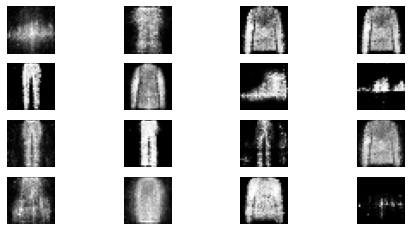

 54%|█████▍    | 27/50 [01:05<00:49,  2.13s/it]

Time for epoch 27 is 2.0478110313415527 sec
Training started with epoch 28 with 469 batches...
Losses after epoch    28: generator 2.197, discriminator 0.947, real_score 67.75%, fake_score 23.75%


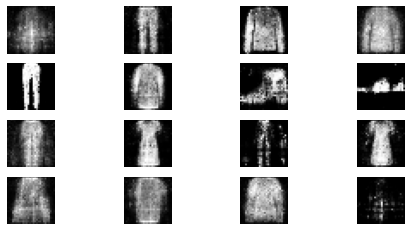

 56%|█████▌    | 28/50 [01:08<00:52,  2.39s/it]

Time for epoch 28 is 2.969860076904297 sec
Training started with epoch 29 with 469 batches...
Losses after epoch    29: generator 1.549, discriminator 0.855, real_score 75.09%, fake_score 31.03%


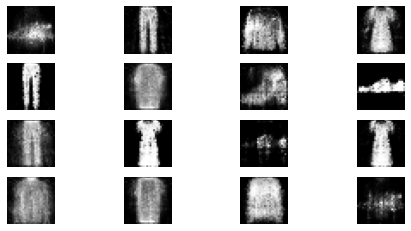

 58%|█████▊    | 29/50 [01:10<00:48,  2.30s/it]

Time for epoch 29 is 2.082247257232666 sec
Training started with epoch 30 with 469 batches...
Losses after epoch    30: generator 1.875, discriminator 1.042, real_score 68.77%, fake_score 24.38%


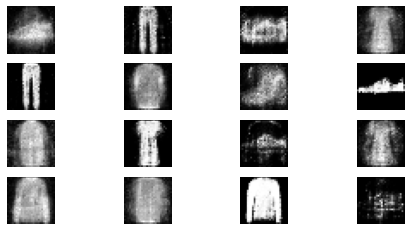

 60%|██████    | 30/50 [01:13<00:45,  2.30s/it]

Time for epoch 30 is 2.2946009635925293 sec
Training started with epoch 31 with 469 batches...
Losses after epoch    31: generator 1.976, discriminator 0.810, real_score 75.08%, fake_score 23.32%


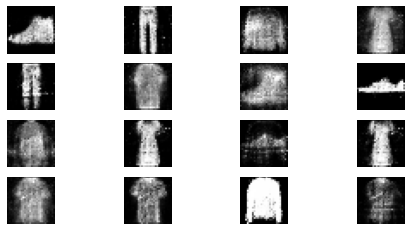

 62%|██████▏   | 31/50 [01:15<00:44,  2.34s/it]

Time for epoch 31 is 2.4360949993133545 sec
Training started with epoch 32 with 469 batches...
Losses after epoch    32: generator 2.021, discriminator 0.691, real_score 80.92%, fake_score 26.14%


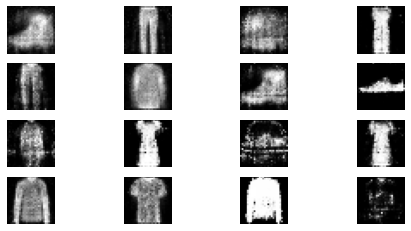

 64%|██████▍   | 32/50 [01:17<00:41,  2.28s/it]

Time for epoch 32 is 2.149752616882324 sec
Training started with epoch 33 with 469 batches...
Losses after epoch    33: generator 2.982, discriminator 0.491, real_score 82.22%, fake_score 12.45%


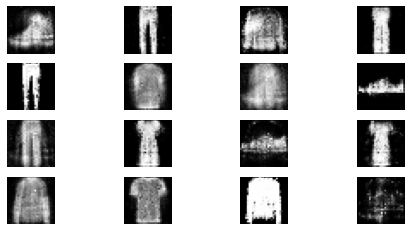

 66%|██████▌   | 33/50 [01:19<00:37,  2.22s/it]

Time for epoch 33 is 2.073728322982788 sec
Training started with epoch 34 with 469 batches...
Losses after epoch    34: generator 1.899, discriminator 0.830, real_score 70.67%, fake_score 23.78%


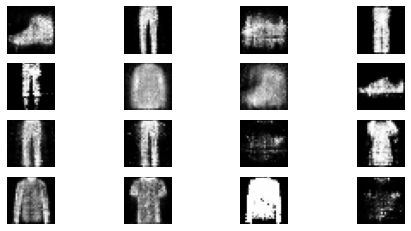

 68%|██████▊   | 34/50 [01:21<00:34,  2.17s/it]

Time for epoch 34 is 2.0384175777435303 sec
Training started with epoch 35 with 469 batches...
Losses after epoch    35: generator 2.215, discriminator 1.035, real_score 76.65%, fake_score 27.67%


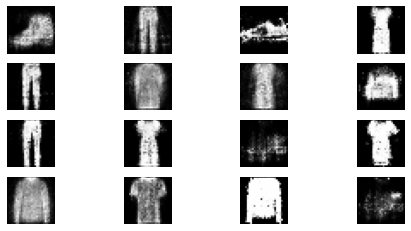

 70%|███████   | 35/50 [01:25<00:37,  2.50s/it]

Time for epoch 35 is 3.268444538116455 sec
Training started with epoch 36 with 469 batches...
Losses after epoch    36: generator 3.064, discriminator 0.519, real_score 84.79%, fake_score 13.97%


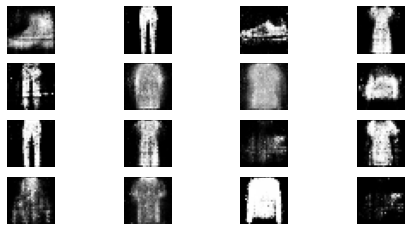

 72%|███████▏  | 36/50 [01:28<00:37,  2.70s/it]

Time for epoch 36 is 3.162257194519043 sec
Training started with epoch 37 with 469 batches...
Losses after epoch    37: generator 1.707, discriminator 0.683, real_score 75.73%, fake_score 24.54%


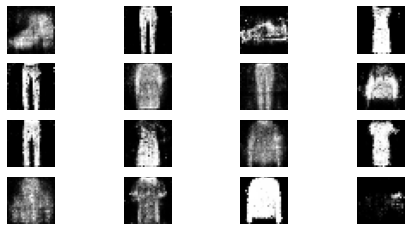

 74%|███████▍  | 37/50 [01:30<00:33,  2.55s/it]

Time for epoch 37 is 2.1771812438964844 sec
Training started with epoch 38 with 469 batches...
Losses after epoch    38: generator 2.359, discriminator 0.756, real_score 83.21%, fake_score 27.07%


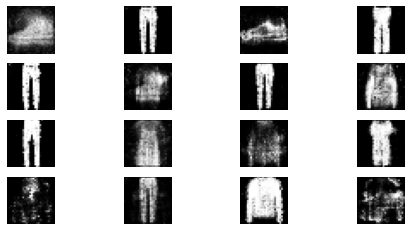

 76%|███████▌  | 38/50 [01:32<00:29,  2.43s/it]

Time for epoch 38 is 2.1599507331848145 sec
Training started with epoch 39 with 469 batches...
Losses after epoch    39: generator 2.757, discriminator 0.881, real_score 68.45%, fake_score 15.77%


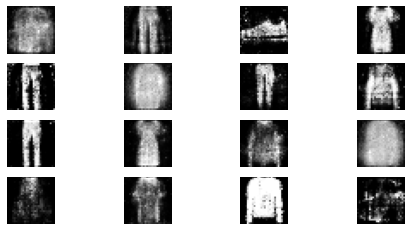

 78%|███████▊  | 39/50 [01:34<00:25,  2.35s/it]

Time for epoch 39 is 2.150920867919922 sec
Training started with epoch 40 with 469 batches...
Losses after epoch    40: generator 1.975, discriminator 1.002, real_score 66.70%, fake_score 23.24%


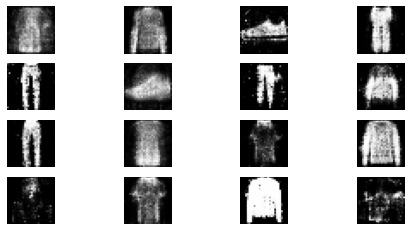

 80%|████████  | 40/50 [01:37<00:23,  2.38s/it]

Time for epoch 40 is 2.434288501739502 sec
Training started with epoch 41 with 469 batches...
Losses after epoch    41: generator 2.088, discriminator 0.719, real_score 75.39%, fake_score 21.41%


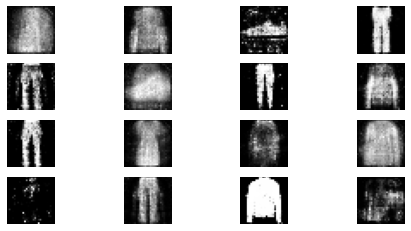

 82%|████████▏ | 41/50 [01:39<00:20,  2.29s/it]

Time for epoch 41 is 2.098567485809326 sec
Training started with epoch 42 with 469 batches...
Losses after epoch    42: generator 1.630, discriminator 1.076, real_score 63.93%, fake_score 28.45%


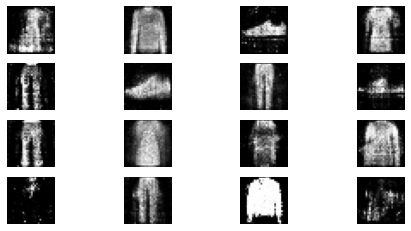

 84%|████████▍ | 42/50 [01:41<00:17,  2.24s/it]

Time for epoch 42 is 2.114621639251709 sec
Training started with epoch 43 with 469 batches...
Losses after epoch    43: generator 1.760, discriminator 0.846, real_score 78.29%, fake_score 29.27%


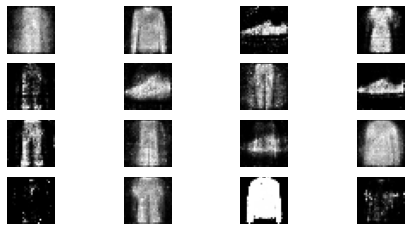

 86%|████████▌ | 43/50 [01:43<00:15,  2.21s/it]

Time for epoch 43 is 2.134120225906372 sec
Training started with epoch 44 with 469 batches...
Losses after epoch    44: generator 1.423, discriminator 1.102, real_score 73.13%, fake_score 33.85%


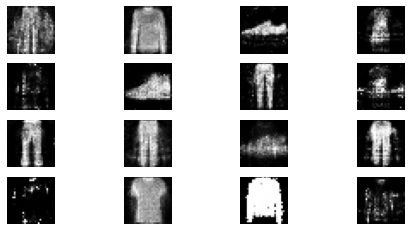

 88%|████████▊ | 44/50 [01:45<00:13,  2.24s/it]

Time for epoch 44 is 2.3142409324645996 sec
Training started with epoch 45 with 469 batches...
Losses after epoch    45: generator 1.970, discriminator 1.195, real_score 63.15%, fake_score 23.69%


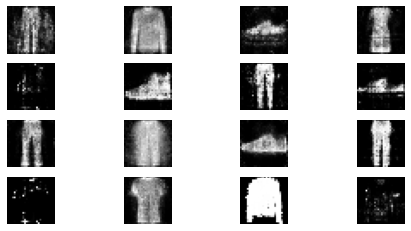

 90%|█████████ | 45/50 [01:47<00:10,  2.19s/it]

Time for epoch 45 is 2.0596539974212646 sec
Training started with epoch 46 with 469 batches...
Losses after epoch    46: generator 1.952, discriminator 0.833, real_score 70.77%, fake_score 23.18%


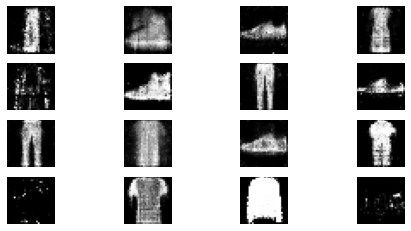

 92%|█████████▏| 46/50 [01:50<00:08,  2.16s/it]

Time for epoch 46 is 2.09346079826355 sec
Training started with epoch 47 with 469 batches...
Losses after epoch    47: generator 1.469, discriminator 1.174, real_score 72.58%, fake_score 34.84%


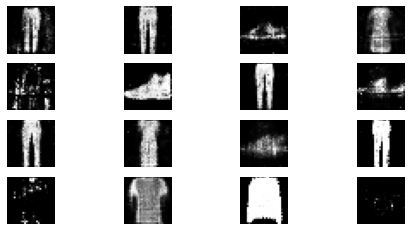

 94%|█████████▍| 47/50 [01:52<00:06,  2.13s/it]

Time for epoch 47 is 2.0465314388275146 sec
Training started with epoch 48 with 469 batches...
Losses after epoch    48: generator 2.114, discriminator 0.843, real_score 68.86%, fake_score 21.43%


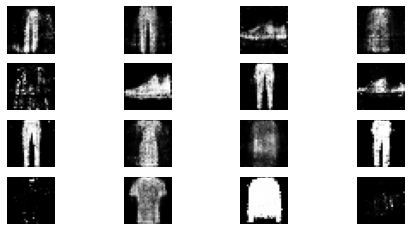

 96%|█████████▌| 48/50 [01:54<00:04,  2.14s/it]

Time for epoch 48 is 2.157073497772217 sec
Training started with epoch 49 with 469 batches...
Losses after epoch    49: generator 2.172, discriminator 0.667, real_score 75.76%, fake_score 20.36%


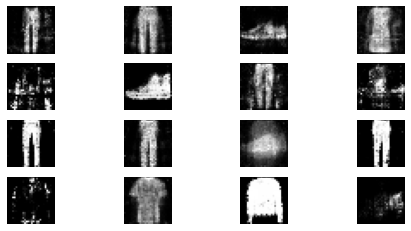

 98%|█████████▊| 49/50 [01:57<00:02,  2.46s/it]

Time for epoch 49 is 3.217268705368042 sec
Training started with epoch 50 with 469 batches...
Losses after epoch    50: generator 2.375, discriminator 0.588, real_score 83.83%, fake_score 21.14%


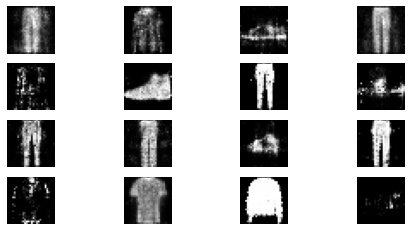

100%|██████████| 50/50 [01:59<00:00,  2.39s/it]

Time for epoch 50 is 2.0924346446990967 sec


In [ ]:
gen_loss_epochs, disc_loss_epochs, real_score_list, fake_score_list = train(train_dataset, epochs=epochs)

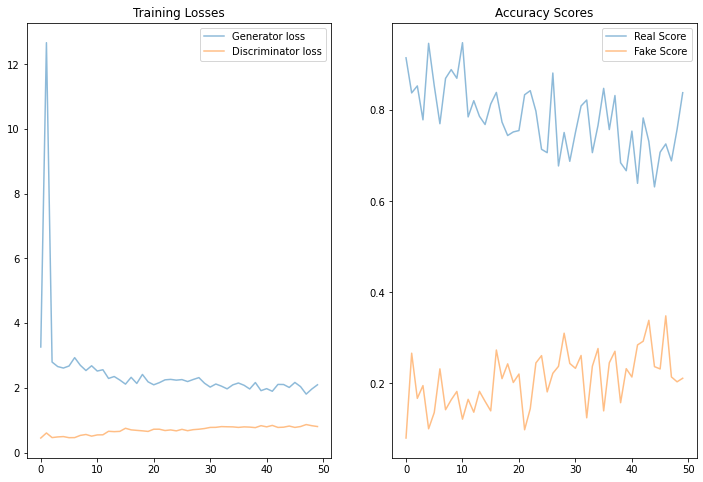

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,8))

ax1.plot(gen_loss_epochs, label = 'Generator loss', alpha=0.5)
ax1.plot(disc_loss_epochs, label = 'Discriminator loss', alpha=0.5)
ax1.legend()

ax1.set_title('Training Losses')
ax2.plot(real_score_list, label = 'Real Score', alpha = 0.5)
ax2.plot(fake_score_list, label = 'Fake Score', alpha = 0.5)
ax2.set_title('Accuracy Scores')

ax2.legend()